In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append("../lib")
import segmentation as sg

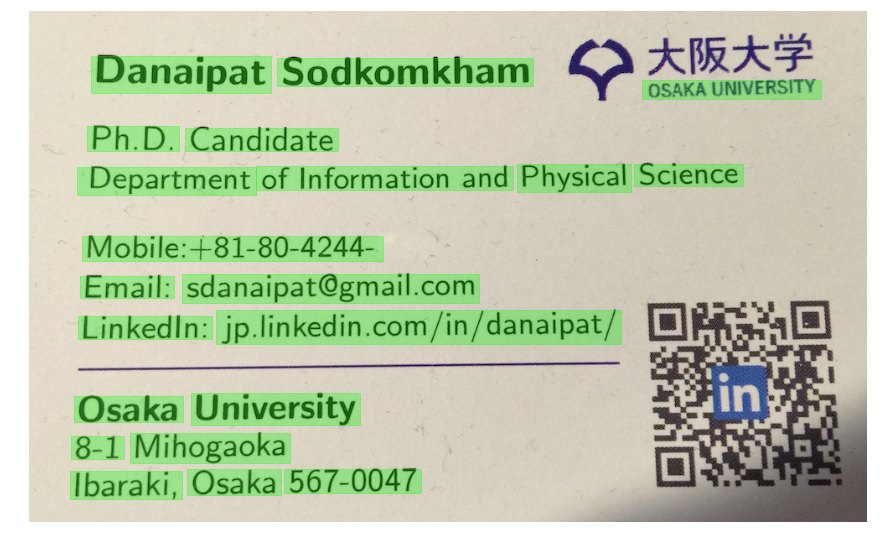

In [36]:
from skimage import io
reload(sg)
    
img = io.imread('../data/card.jpg')
text_segments = sg.text_segments(img)

plt.gcf().set_size_inches(15, 10)
plt.axis('off')
plt.imshow(img, cmap=plt.cm.gray)
ax = plt.gca()

for s in text_segments:
    ax.add_patch(matplotlib.patches.Rectangle((s[1], s[0]), s[3] - s[1], s[2] - s[0], color=(0, 1, 0, 0.3)))

In [35]:
def extract(img, segment):
    return img[segment[0]:segment[2], segment[1]:segment[3]]

In [56]:
grayscale_img = sg.rgb2grayscale(img)
segments = [extract(grayscale_img, seg) for seg in text_segments]

plt.gcf().set_size_inches(15, 5)
for i, s in enumerate(segments):
    plt.subplot(len(segments)/3, 3, i + 1)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.imshow(s, cmap=plt.cm.gray)

In [ ]:
# generate artificial training data
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import string
import random


characters = string.ascii_letters + string.digits
font_path = "/Library/Fonts/"
font_choices = ["Arial.ttf",
                "Arial Black.ttf",
                "Arial Bold Italic.ttf",
                "Arial Bold.ttf",
                "Arial Italic.ttf",
                "Arial Narrow Bold Italic.ttf",
                "Arial Narrow Bold.ttf",
                "Arial Narrow Italic.ttf",
                "Arial Narrow.ttf",
                "Arial Rounded Bold.ttf",
                "Arial Unicode.ttf"]

W = 24
H = 24    

i = 0
repeat = 10
            

for a in characters:
    for b in characters:
        for shift in [-6, -5, -4, -3, -2, 2, 3, 4, 5, 6]:
            img = Image.new("L", (W, H), 255 - random.randint(0, 50))
            draw = ImageDraw.Draw(img)
            font_name = random.choice(font_choices)
            font = ImageFont.truetype(font_path+font_name, 40)
            w1, _ = draw.textsize(a, font=font)
            w2, _ = draw.textsize(b, font=font)
            w, _ = draw.textsize(a + b, font=font)
            mid = (w1 + (w - w1 - w2) / 2)
            draw.text((-(mid - W/2) + shift, -14), a + b, random.randint(0, 50), font=font)
            img.save("../data/character_segmentation3/neg/%d.png" % i)
            i += 1


In [119]:
# generate artificial training data
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import string
import random


characters = string.ascii_letters + string.digits
font_path = "/Library/Fonts/"
font_choices = ["Arial.ttf",
                "Arial Black.ttf",
                "Arial Bold Italic.ttf",
                "Arial Bold.ttf",
                "Arial Italic.ttf",
                "Arial Narrow Bold Italic.ttf",
                "Arial Narrow Bold.ttf",
                "Arial Narrow Italic.ttf",
                "Arial Narrow.ttf",
                "Arial Rounded Bold.ttf",
                "Arial Unicode.ttf"]

W = 24
H = 24    

i = 0
repeat = 10
            

for a in characters:
    for b in characters:
        for _ in range(repeat):
            img = Image.new("L", (W, H), 255 - random.randint(0, 50))
            draw = ImageDraw.Draw(img)
            font_name = random.choice(font_choices)
            font = ImageFont.truetype(font_path+font_name, 40)
            w1, _ = draw.textsize(a, font=font)
            w2, _ = draw.textsize(b, font=font)
            w, _ = draw.textsize(a + b, font=font)
            mid = (w1 + (w - w1 - w2) / 2)
            draw.text((-(mid - W/2), -14), a + b, random.randint(0, 50), font=font)
            img.save("../data/character_segmentation3/pos/%d.png" % i)
            i += 1


In [3]:
from skimage import io
import os

W = 24
H = 24 

path, dirs, files = os.walk("../data/character_segmentation3/pos").next()
N_pos = len(files)

path, dirs, files = os.walk("../data/character_segmentation3/neg").next()
N_neg = len(files)

pos = np.zeros((N_pos, H, W))
neg = np.zeros((N_neg, H, W))

for i in range(N_pos):
    pos[i] = io.imread("../data/character_segmentation3/pos/%d.png" % i)


for i in range(N_neg):
    neg[i] = io.imread("../data/character_segmentation3/neg/%d.png" % i)

print N_pos, N_neg

38440 38440


In [4]:
N = N_pos + N_neg
X = np.vstack((pos, neg)).reshape(N, W*H).astype(np.float32)
y = np.array([1] * N_pos + [0] * N_neg).astype(np.int32)

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [6]:
from lasagne.nonlinearities import softmax
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

net = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, H, W),
    conv1_num_filters=16, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2), dropout1_p=0.1,
    hidden4_num_units=256, dropout4_p=0.35,
    hidden5_num_units=256,
    output_num_units=2, 
    output_nonlinearity=softmax,

    update_learning_rate=0.0001,
    update_momentum=0.9,

    regression=False,
    max_epochs=1000,
    verbose=1,
    )

Using gpu device 0: Quadro K420


In [7]:
indexes = range(N)
np.random.shuffle(indexes)

net = net.fit(X.reshape(N, 1, H, W)[indexes], y[indexes])

# Neural Network with 562338 learnable parameters

## Layer information

  #  name      size
---  --------  --------
  0  input     1x24x24
  1  conv1     16x22x22
  2  pool1     16x11x11
  3  dropout1  16x11x11
  4  hidden4   256
  5  dropout4  256
  6  hidden5   256
  7  output    2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       0.50417       0.35138      1.43483      0.86958  14.58s
      2       0.35202       0.29982      1.17413      0.88036  14.53s
      3       0.31985       0.28335      1.12881      0.88914  14.54s
      4       0.30588       0.27360      1.11799      0.89308  14.53s
      5       0.29554       0.26673      1.10804      0.89689  14.52s
      6       0.28902       0.26127      1.10620      0.89954  14.54s
      7       0.28194       0.25682      1.09781      0.90186  14.52s
      8       0.27928       0.25307      1.10358      0.90418  14.54s
      9       0.

/home/jo/anaconda/lib/python2.7/site-packages/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "
/home/jo/anaconda/lib/python2.7/site-packages/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "


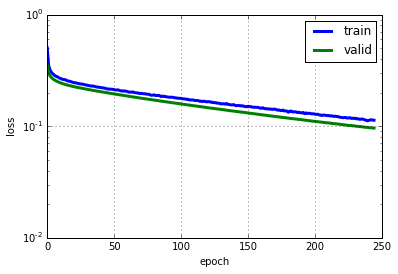

In [8]:
train_loss = np.array([i["train_loss"] for i in net.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
pyplot.plot(train_loss, linewidth=3, label="train")
pyplot.plot(valid_loss, linewidth=3, label="valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.yscale("log")
pyplot.show()

In [13]:
import cPickle as pickle
with open('net-conv.pickle', 'wb') as f:
    pickle.dump(net, f, -1)

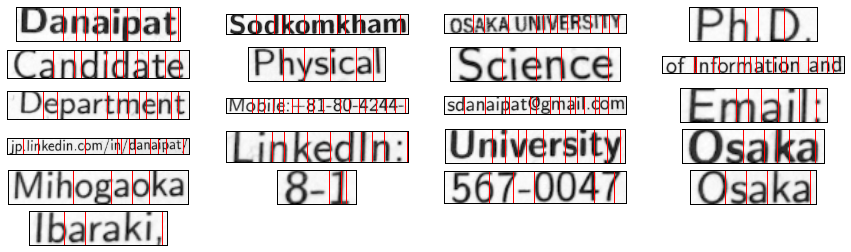

In [70]:
from skimage.transform import resize

plt.gcf().set_size_inches(15, 5)

grayscale_img = sg.rgb2grayscale(img)
segments = [extract(grayscale_img, seg) for seg in sg.text_segments(img)]

step = 3

for j, s in enumerate(segments):
    plt.subplot(len(segments)/step, step+1, j + 1)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    ratio = 1. * s.shape[0] / s.shape[1]
    im = resize(s.astype(np.float64), (H, int(H / ratio)))
    cut_pts = []

    for i in range(0, im.shape[1] - W, step):
        x = scaler.transform(im[:, i:i+W].reshape(1, -1))
        cut = net.predict(x.reshape(1, 1, H, W).astype(np.float32))
        if cut:
            cut_pts.append(i + W)
            
    plt.imshow(im, cmap=plt.cm.gray)
    for c in cut_pts:
        plt.axvline(c, 0, 22, c='r')

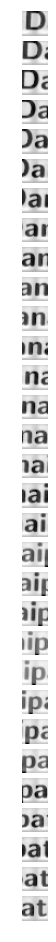

In [101]:
s = segments[0]
ratio = 1. * s.shape[0] / s.shape[1]
im = resize(s.astype(np.float64), (H, int(H / ratio)))

step = 3


plt.gcf().set_size_inches(5, 20)

j = 0
for i in range(0, im.shape[1] - W, step):
    plt.subplot(im.shape[1] / step, 1, j + 1)
    plt.axis('off')

    x = scaler.transform(im[:, i:i+W].reshape(1, -1))
    plt.imshow(x.reshape(W, H), cmap = plt.cm.gray)
    
    j += 1

